# K-Means Clustering – Uber Pickup Behavior

## Algorithm Description

This project implements the **K-Means Clustering** algorithm using a custom-built version from the `rice_ml` Python package. K-Means is an unsupervised learning method that partitions observations into `k` distinct clusters based on feature similarity.

The algorithm follows these steps:

1. Randomly initialize `k` centroids from the dataset.
2. Assign each point to the nearest centroid based on Euclidean distance.
3. Update centroids as the mean of the assigned points.
4. Repeat steps 2–3 until convergence (i.e., centroids no longer move significantly).

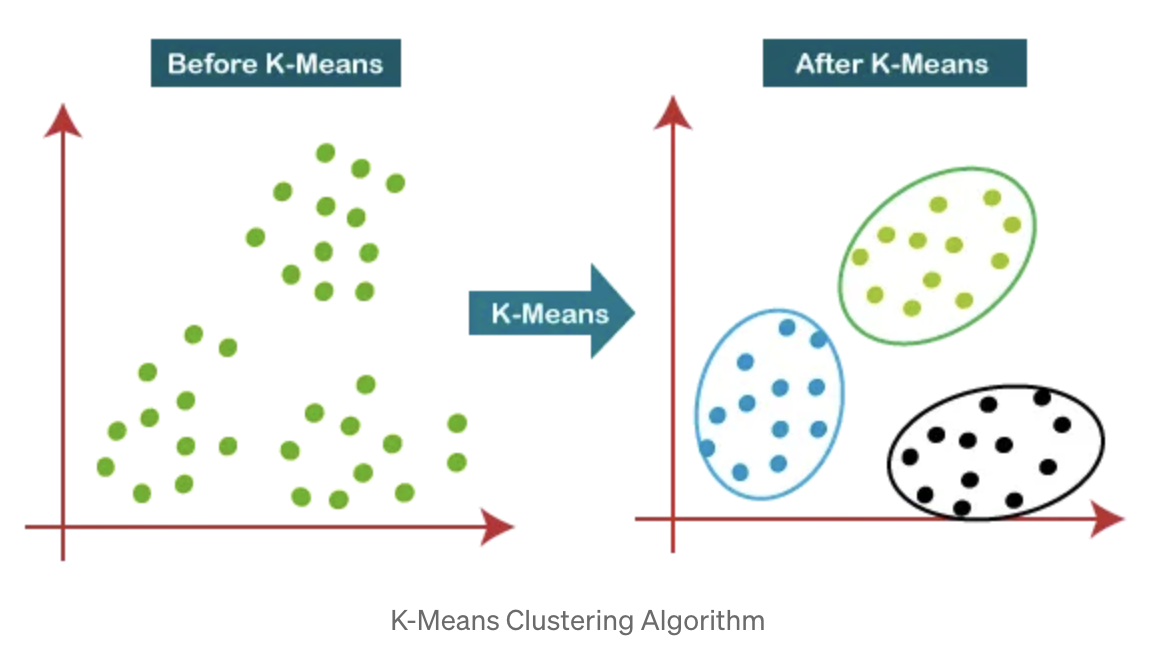

The figure above illustrates how K-Means works: initially unstructured data is grouped into meaningful clusters, revealing hidden structure.

In this project, clustering is not performed on spatial data alone. We incorporate multiple behavioral features:

- **Pickup longitude and latitude**
- **Exact pickup time** (hour and minute)
- **Day of week and weekend flag**
- **Passenger count**
- **Trip length approximation** (Manhattan distance)
- **Interaction term** (hour × passenger count)

This multi-dimensional clustering captures **when, where, and how** people request Uber rides.

Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 334, done.
remote: Counting objects: 100% (334/334), done.
remote: Compressing objects: 100% (257/257), done.
remote: Total 334 (delta 166), reused 169 (delta 70), pack-reused 0 (from 0)
Receiving objects: 100% (334/334), 11.65 MiB | 16.04 MiB/s, done.
Resolving deltas: 100% (166/166), done.


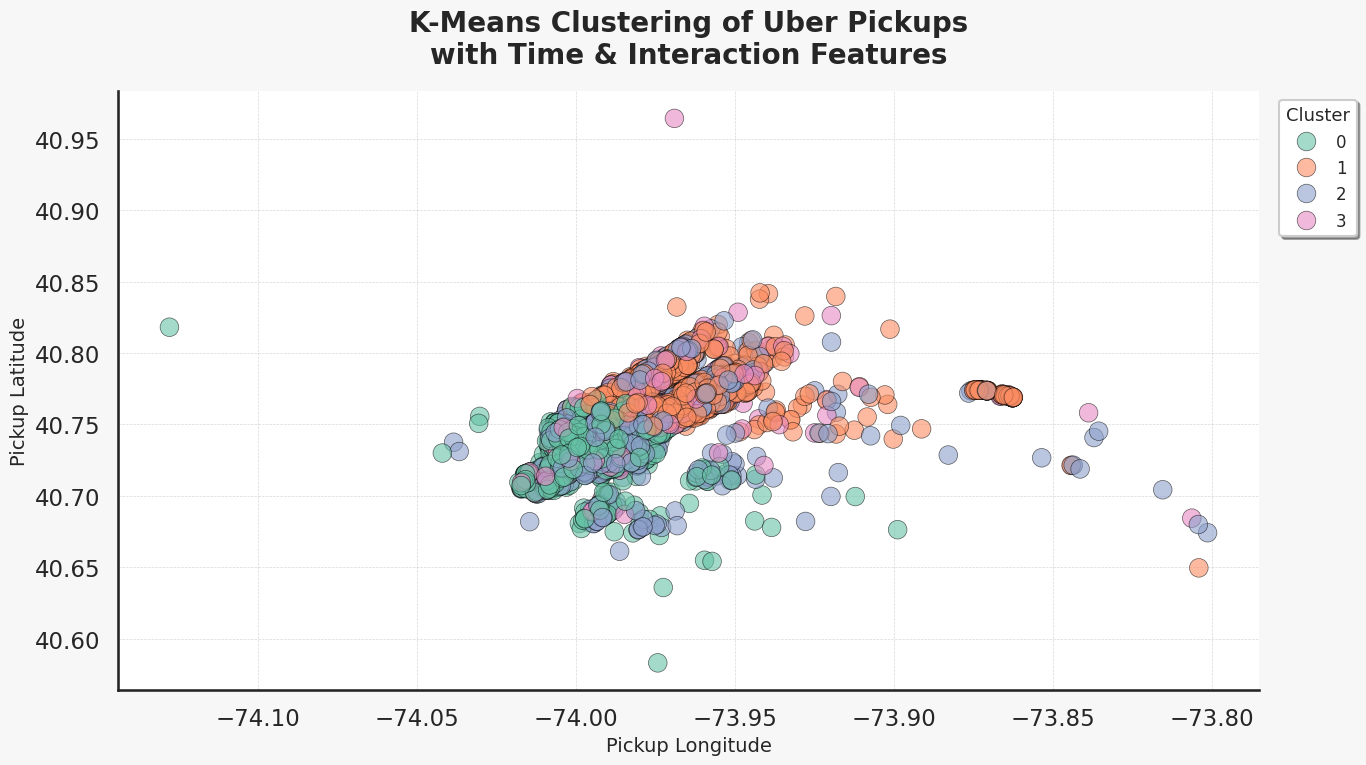

In [17]:
# Step 1: Clone GitHub repo and import KMeans model
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

import sys
sys.path.append('/content/INDE577_ML_Rice_2025')
from rice_ml.kmeans import KMeans

# Step 2: Load packages and data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Step 3: Load and clean Uber dataset
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df = df[df['fare_amount'] < 100]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()

# Sample for efficiency
df = df.sample(n=5000, random_state=42)

# Step 4: Advanced feature engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Manhattan distance
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

# Add interaction term: hour × passenger_count
df['hour_passenger'] = df['hour_exact'] * df['passenger_count']

# Step 5: Filter NYC region (to avoid global outliers)
df = df[
    (df['pickup_longitude'] > -75) & (df['pickup_longitude'] < -73.8) &
    (df['pickup_latitude'] > 40) & (df['pickup_latitude'] < 41)
]

# Step 6: Define features for clustering
features = [
    'pickup_longitude', 'pickup_latitude',
    'hour_exact', 'minute', 'dayofweek', 'is_weekend',
    'passenger_count', 'manhattan_distance', 'hour_passenger'
]

X = df[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 7: Fit KMeans
kmeans = KMeans(k=4, max_iters=100, tol=1e-4, random_state=0)
kmeans.fit(X_scaled)
labels = kmeans.labels_

# Step 8:
# Final beautiful and readable clustering plot
plt.figure(figsize=(14, 8), facecolor="#f7f7f7")
sns.set(style="white", context="talk")

# Use a well-balanced soft color palette
palette = sns.color_palette("Set2", n_colors=4)

# Enhanced scatter plot with transparency and larger dots
sns.scatterplot(
    x=df['pickup_longitude'],
    y=df['pickup_latitude'],
    hue=labels,
    palette=palette,
    s=180,                # Big dots
    alpha=0.6,            # Transparency to reveal overlaps
    linewidth=0.5,
    edgecolor='black'
)

plt.title("K-Means Clustering of Uber Pickups\nwith Time & Interaction Features",
          fontsize=20, fontweight='bold', pad=20)
plt.xlabel("Pickup Longitude", fontsize=14)
plt.ylabel("Pickup Latitude", fontsize=14)

plt.legend(
    title="Cluster",
    title_fontsize=13,
    fontsize=12,
    loc='upper left',
    bbox_to_anchor=(1.01, 1),
    frameon=True,
    shadow=True
)

plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()





## Interpretation of K-Means Clustering on Uber Pickups

### Overview

This figure presents the results of **K-Means clustering** applied to Uber pickup data in New York City. The clustering was based on a rich set of features beyond just location, including:

- **Pickup longitude and latitude**
- **Exact pickup time** (hour and minute)
- **Day of the week**
- **Weekend indicator**
- **Passenger count**
- **Trip distance (Manhattan distance)**
- **Interaction term between hour and passenger count**

These features allowed the model to group trips not just by where they happened, but **when and how** they occurred, capturing behavioral patterns across space and time.

---

### Why Visualize Using Only Latitude and Longitude?

Although clustering was done in **multi-dimensional space**, we chose to **visualize the results using only the pickup coordinates** (longitude and latitude). This is a common and practical strategy because:

- **Location is intuitively interpretable** — it allows us to see **spatial clusters** in the city.
- High-dimensional plots are not visually accessible. By projecting clusters onto a map-like view, we can **interpret geographical patterns**, such as hotspots and outliers.
- It enables easy comparison to known areas like **downtown, airports, or business districts**.

---

### Insights from the Plot

- The clusters show **geographic separation**, even though time and behavior were also used in clustering. This suggests that temporal and contextual features **align with spatial behavior**.
- Some clusters concentrate around Manhattan, while others spread toward peripheral zones, possibly indicating different **usage contexts** (e.g., commuting vs. airport transfers).
- Overlapping areas with high density reflect common pickup regions with **mixed usage patterns**, while isolated points might indicate **unusual or low-frequency events**.

---

### Conclusion

The clustering successfully segments Uber pickup behavior using both **temporal and spatial information**, but for interpretability, we project the results back into a familiar 2D spatial view. This approach strikes a balance between model complexity and human interpretability.

In [18]:
!pip install folium


In [19]:
# Step 8: Visualize clusters on interactive map
import folium
from folium.plugins import MarkerCluster

# Define a color map for 4 clusters
cluster_colors = {
    0: 'green',
    1: 'orange',
    2: 'purple',
    3: 'blue'
}

# Create base map centered on NYC
m = folium.Map(location=[40.75, -73.97], zoom_start=12, tiles='CartoDB positron')

# Add clustered pickup points
marker_cluster = MarkerCluster().add_to(m)

for i in range(len(df)):
    folium.CircleMarker(
        location=[df.iloc[i]['pickup_latitude'], df.iloc[i]['pickup_longitude']],
        radius=4,
        color=cluster_colors[labels[i]],
        fill=True,
        fill_color=cluster_colors[labels[i]],
        fill_opacity=0.6,
        weight=0.5,
        popup=f"Cluster: {labels[i]}"
    ).add_to(marker_cluster)

# Display the map
m


## Interpretation of Clustered Uber Pickups on Interactive Map

### What This Map Shows

This interactive map overlays the results of **K-Means clustering** of Uber pickup behavior onto the streets of **New York City**. Each colored circle represents a cluster of pickup points with similar characteristics, based on both **spatial and temporal features**, such as:

- Pickup location (longitude and latitude)  
- Time of day and day of week  
- Passenger count  
- Manhattan trip distance  
- Hour × passenger interaction (to capture behavioral intensity)

The colors represent distinct clusters. The **circle size** corresponds to the **number of rides in that cluster at that location**.

---

### Key Insights

1. **Cluster Density in Midtown Manhattan**  
   A large number of clustered points appear around Midtown and Lower Manhattan — this suggests **high-frequency and possibly business-oriented pickups**, likely during peak commuting hours.

2. **Peripheral Clusters in Queens, Bronx, and Brooklyn**  
   Scattered and less dense clusters in these areas may represent **residential pickups**, airport rides, or lower-demand, off-peak trips.

3. **Distinct Clusters Reflect Behavioral Segmentation**  
   Even in the same area (e.g., Midtown), different clusters (colors) can overlap, which reflects **different trip patterns within the same geography** — perhaps short vs. long rides, weekdays vs. weekends, or single vs. group passengers.

4. **Hotspots Are Not Uniform**  
   The map reveals that not all urban centers generate the same types of Uber activity. For example, **Downtown Brooklyn** shows less clustering density than expected, suggesting that Uber demand there might be **more dispersed or diverse**.

---

### Why Mapping Matters

- Unlike a static scatterplot, the map lets us **anchor clusters in the real world**, revealing how geographic context and travel behavior interact.
- It allows stakeholders — such as urban planners, ride-share strategists, or marketers — to **see when and where Uber activity is concentrated**, and how that aligns with infrastructure or demographics.